# Inference and Final Predictions

In [1]:
from dataset import ClassificationDataset
from engine import get_data
from model import Net
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import config
import torch
import glob
%matplotlib inline

## Helper functions

In [2]:
# helper functions
def visualize_tensor_image(image: torch.tensor):
    numpy_image = image.numpy()
    # in pytorch the input image aray should be in format NCHW
    # batch N, channels C, height H, width W.
    # reverting back the array to normal format W * H * C
    numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.imshow(numpy_image)

## Inference

In [3]:


def inference(model, test_dataset, device):
    """
    to make predictions or inference
    """
    model.to(device)
    data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=1)
    # initialize empty lists to store predictions
    # and targets
    final_predictions = []
    # put the model in eval mode
    model.eval()
    # disable gradient calculation
    with torch.no_grad():
        for data in data_loader:
            images = data['images']
            # move everything to specified device
            images = images.to(device, dtype=torch.float)
            # make predictions
            outputs = model(images)
            # move predictions and targets to list
            # we need to move predictions and targets to cpu too
            # convert outputs to cpu and extend the final list
            outputs = torch.sigmoid(outputs).cpu().detach()
            outputs = outputs.numpy().tolist()
            final_predictions.extend(outputs)
    return final_predictions



## Read the data

In [4]:
df = pd.read_csv("test_data/test_data.csv")

In [5]:
df['image_path'] = df.image_name.apply(lambda x: join("test_data/test_images", x))

In [6]:
df.sample(5)

,image_name,target,image_path
8,0_cd99f84b-a525-11ed-9cbd-17d309d3e4d0.jpeg,0,test_data/test_images/0_cd99f84b-a525-11ed-9cb...
11,0_cd99f855-a525-11ed-9cbd-17d309d3e4d0.jpeg,0,test_data/test_images/0_cd99f855-a525-11ed-9cb...
1,0_cd99f843-a525-11ed-9cbd-17d309d3e4d0.jpeg,0,test_data/test_images/0_cd99f843-a525-11ed-9cb...
20,1_cd99f851-a525-11ed-9cbd-17d309d3e4d0.jpeg,1,test_data/test_images/1_cd99f851-a525-11ed-9cb...
2,0_cd99f844-a525-11ed-9cbd-17d309d3e4d0.jpeg,0,test_data/test_images/0_cd99f844-a525-11ed-9cb...


## Prepare Dataset

In [7]:
test_dataset = ClassificationDataset(
    image_paths=df.image_path.to_list(),
    # for validation no need for augmentation
    to_augment=False,
    test_data=True
)

In [8]:
test_dataset[0]

{'images': tensor([[[-1.9980, -2.0494, -2.1008,  ...,  1.5639,  1.5982,  1.6495],
          [-2.0494, -2.1008, -2.0665,  ...,  1.4269,  1.4954,  1.5125],
          [-2.0837, -2.1179, -2.0837,  ...,  0.1939,  0.5707,  0.8276],
          ...,
          [ 0.5193,  0.5193,  0.5193,  ...,  1.8722,  1.9578,  1.9064],
          [ 0.3994,  0.3994,  0.4337,  ...,  1.8550,  1.8893,  1.8893],
          [ 0.2796,  0.2796,  0.2967,  ...,  1.8208,  1.8379,  1.8893]],
 
         [[ 0.4328,  0.4503,  0.5028,  ...,  1.6232,  1.6057,  1.6408],
          [ 0.4678,  0.4153,  0.4153,  ...,  1.4132,  1.4482,  1.4832],
          [ 0.5203,  0.3102,  0.2227,  ...,  0.0826,  0.4503,  0.6954],
          ...,
          [ 1.3256,  1.3256,  1.3256,  ...,  1.6933,  1.7633,  1.6933],
          [ 1.2381,  1.2381,  1.2731,  ...,  1.6232,  1.6758,  1.6933],
          [ 1.1155,  1.1155,  1.1331,  ...,  1.5707,  1.6232,  1.6933]],
 
         [[ 1.6291,  1.6291,  1.6465,  ...,  0.7576,  0.8448,  0.9319],
          [ 1.6988

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


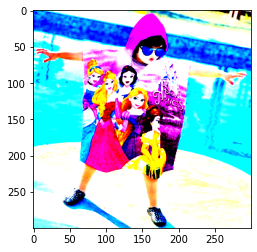

In [9]:
visualize_tensor_image(test_dataset[0]['images'])

# Model

In [10]:
%%time
model = Net()
print("loading from path", config.MODEL_PATH)
model.load_state_dict(torch.load(config.MODEL_PATH, map_location=torch.device('cpu')))
available_device = "cuda" if torch.cuda.is_available() else "cpu"
print("available device is: ", available_device)
predictions = inference(model, test_dataset, available_device)
outputs = np.array(predictions) >= 0.5
predictions = outputs.flatten()

loading from path outputs/model.bin
available device is:  cpu
CPU times: user 6.75 s, sys: 2.34 s, total: 9.09 s
Wall time: 1.55 s


## F1 Score

In [11]:
f1_score(predictions, df.target.to_list())

0.8000000000000002

## Accuracy

In [12]:
accuracy_score(predictions, df.target.to_list())

0.7692307692307693

## Confusion Matrix

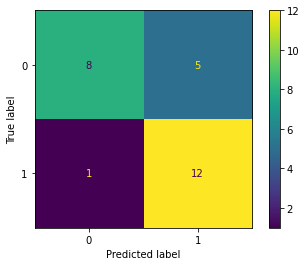

In [13]:
conf_m  = confusion_matrix(df.target.to_list(), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_m)
disp.plot()
plt.show()

In [14]:
df.groupby(by=['target']).count()

,image_name,image_path
target,,
0,13,13
1,13,13


# Plot predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

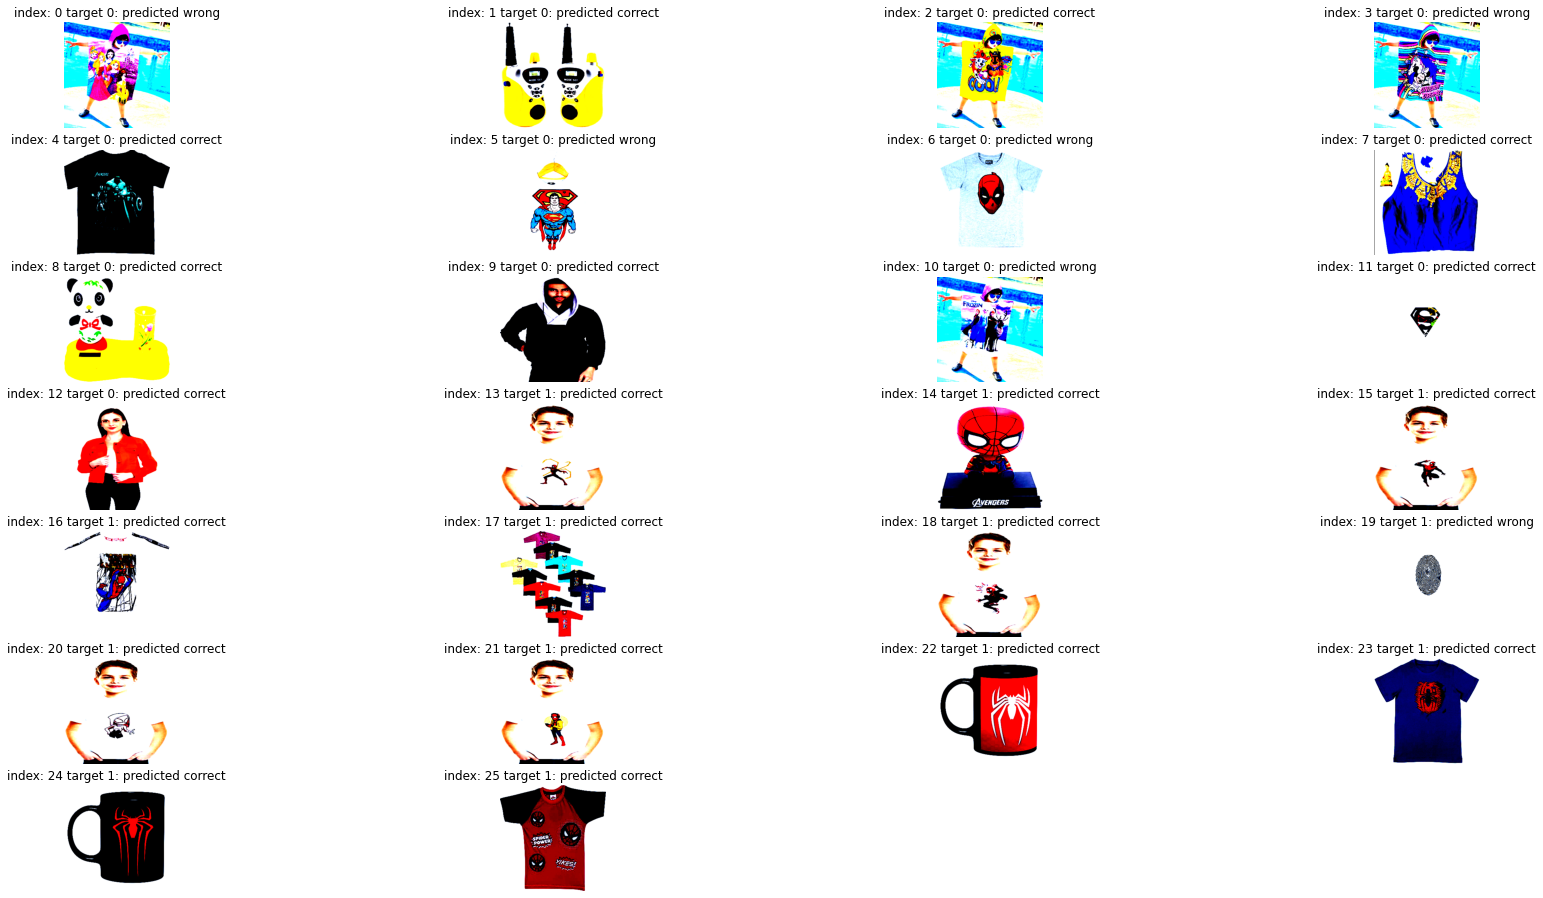

In [15]:
targets = df.target.values

# plt.imshow(numpy_image)
fig = plt.figure(figsize=(30, 30))
rows = 13
columns = 4
for index, data in enumerate(test_dataset):
    image = test_dataset[index]['images']
    numpy_image = image.numpy()
    # in pytorch the input image array should be in format NCHW
    # batch N, channels C, height H, width W.
    # reverting back the array to normal format W * H * C
    numpy_image = np.transpose(numpy_image, (1, 2, 0))
    
    fig.add_subplot(rows, columns, index+1)
    plt.imshow(numpy_image)
    plt.axis('off')
    target = targets[index]
    if predictions[index] != target:
        pred_ = "wrong"
    else:
        pred_ = "correct"
    title = f'index: {index} target {target}: predicted {pred_}'
    plt.title(title)

## Insights 💡

The accuracy of our model on unseen data is only 76.92% but we have a better f1 score of 80%. When we inspect the confusion matrix, out of 13 relevant products we predicted 12 products correctly, there was only one miss prediction. So model performs well in identifying the relevant products

Also, the model miss predicted 5 non-relevant products as Target 1 or relevant ones. But as we discussed earlier, our primary aim was to identify relevant products. From that perspective, our model performed well with minimum manual labeling (76 images) and proper use of open-source datasets. With further optimization techniques, we can achieve a better model which can perform well in the prediction of Target 0 images.



## Final Predictions

final predictions on all unseen images or unidentified images

In [16]:
unseen_images = glob.glob('unseen_images/*')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


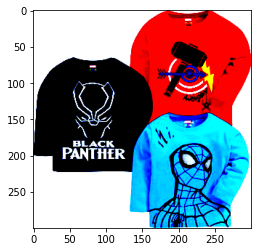

In [17]:
test_dataset = ClassificationDataset(
    image_paths=unseen_images,
    # for validation no need for augmentation
    to_augment=False,
    test_data=True
)
visualize_tensor_image(test_dataset[0]['images'])

In [18]:
%%time
model = Net()
print("loading from path", config.MODEL_PATH)
model.load_state_dict(torch.load(config.MODEL_PATH, map_location=torch.device('cpu')))
available_device = "cuda" if torch.cuda.is_available() else "cpu"
print("available device is: ", available_device)
predictions = inference(model, test_dataset, available_device)
outputs = np.array(predictions) >= 0.5
predictions = outputs.flatten()

loading from path outputs/model.bin
available device is:  cpu
CPU times: user 2min 10s, sys: 46.2 s, total: 2min 56s
Wall time: 29.6 s


In [19]:
final_predictions = pd.DataFrame({"unseen_images": unseen_images, "predictions": predictions})
final_predictions.groupby(by='predictions').count()

,unseen_images
predictions,
False,198
True,317


In [20]:
final_predictions

,unseen_images,predictions
0,unseen_images/KTBGKUBCFRYKC9TP.jpeg,True
1,unseen_images/SWSFKMHGNC5JJVFD.jpeg,False
2,unseen_images/KTBGCZMQZUX3DE3F.jpeg,True
3,unseen_images/KTBGFRYEK4UUD5YS.jpeg,True
4,unseen_images/KTBFR9TFNFFVSNZE.jpeg,True
...,...,...
510,unseen_images/SWSG92UEZGNDVPFJ.jpeg,True
511,unseen_images/BLOG6GVCGAWYCHWN.jpeg,False
512,unseen_images/SWSGKC83R6DMH2TV.jpeg,False
513,unseen_images/KTBG7T7S8QZBEEWZ.jpeg,True
